In [1]:
%reset -f

In [2]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf  # For tf.data
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import EfficientNetB6
from tensorflow.keras.callbacks import EarlyStopping

# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 528
BATCH_SIZE = 64

2024-12-22 11:34:38.326969: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-22 11:34:38.345437: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-22 11:34:38.522970: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-22 11:34:38.687266: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734860079.032337  148146 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734860079.14

In [3]:
# Load the dataset

dataset_dir = "/home/clap/Documents/miniproject_bioinformatic/dataset/dataset_beans_split/sample_750"
builder = tfds.ImageFolder(dataset_dir)
ds_train, ds_test, ds_val = builder.as_dataset(
    split=["train", "test", "validation"], as_supervised=True
)
ds_info = builder.info
NUM_CLASSES = builder.info.features["label"].num_classes


size = (IMG_SIZE, IMG_SIZE)
ds_val = ds_val.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))

2024-12-22 11:34:44.921898: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".
2024-12-22 11:34:45.404881: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
def format_label(label):
    string_label = label_info.int2str(label)
    return string_label

beansImages = {}
label_info = ds_info.features["label"]
for label_name in label_info.names:
    beansImages[label_name] = []
for i, (image, label) in enumerate(ds_train):
    beansImages[format_label(label)].append(image)
for label_name in label_info.names:
    print (f"Total of {label_name} leaves: {len(beansImages[label_name])}")

Total of angular_leaf_spot leaves: 250
Total of bean_rust leaves: 250
Total of healthy leaves: 249


2024-12-22 11:34:45.961281: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


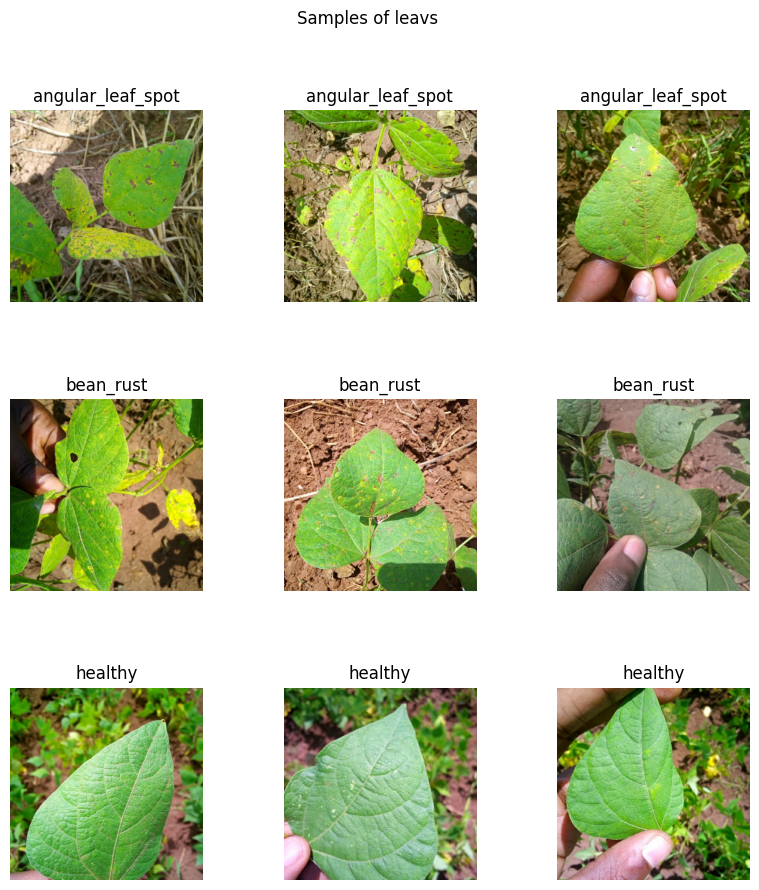

In [5]:
import random

def plot_sample_images():
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.5)
    fig.suptitle('Samples of leavs')
    for i, label in enumerate(beansImages.keys()):
        for j in range(3):
            randeom_index = random.randint(0, len(beansImages[label]) -1)	
            img = beansImages[label][randeom_index].numpy().astype("uint8")
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            axes[i, j].set_title(label)
    plt.show()
plot_sample_images()

In [6]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
    layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    layers.RandomBrightness(factor=0.2),
    layers.GaussianNoise(0.1)
]


def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

In [7]:
# One-hot / categorical encoding
def input_preprocess_train(image, label):
    image = img_augmentation(image)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


def input_preprocess_test(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_val = ds_val.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.batch(batch_size=BATCH_SIZE, drop_remainder=True)

ds_test = ds_test.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True)

In [8]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


In [9]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model = EfficientNetB6(include_top=False, input_tensor=inputs, weights="imagenet")
    
    # Freeze all layers initially
    base_model.trainable = False

    # Add classification head
    x = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation="relu", name="dense_before_output")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3, name="dropout_before_output")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile the model
    model = keras.Model(inputs, outputs, name="EfficientNet")
    
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)  # Reduced learning rate
    model.compile(
        optimizer=optimizer, 
        loss="categorical_crossentropy", 
        metrics=["accuracy"]
    )

    return model

In [10]:

model = build_model(num_classes=NUM_CLASSES)
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=4,          # Stop training after 4 epochs without improvement
    restore_best_weights=True  # Restore the best weights after stopping
)
hist = model.fit(
    ds_train,
    epochs=50,
    validation_data=ds_val,
      callbacks=[early_stopping])



Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 293s 26s/step - accuracy: 0.5843 - loss: 1.2220 - val_accuracy: 0.8516 - val_loss: 0.6119
Epoch 2/50


2024-12-22 11:39:43.065768: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 214106880 bytes after encountering the first element of size 214106880 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


11/11 ━━━━━━━━━━━━━━━━━━━━ 284s 26s/step - accuracy: 0.8530 - loss: 0.3579 - val_accuracy: 0.7812 - val_loss: 0.5852
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 284s 26s/step - accuracy: 0.8824 - loss: 0.3335 - val_accuracy: 0.7344 - val_loss: 0.5800
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 285s 26s/step - accuracy: 0.9313 - loss: 0.1940 - val_accuracy: 0.8438 - val_loss: 0.5044
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 283s 26s/step - accuracy: 0.9323 - loss: 0.2312 - val_accuracy: 0.9141 - val_loss: 0.4459
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 284s 26s/step - accuracy: 0.9221 - loss: 0.2039 - val_accuracy: 0.8359 - val_loss: 0.4697
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 283s 26s/step - accuracy: 0.9171 - loss: 0.2526 - val_accuracy: 0.9141 - val_loss: 0.4222
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 282s 26s/step - accuracy: 0.9292 - loss: 0.1688 - val_accuracy: 0.8359 - val_loss: 0.4375
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 285s 26s/step - accuracy: 0.9014 - loss: 0.2716 - val_accuracy: 0.8906 - val_

2024-12-22 12:31:50.255652: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 214106880 bytes after encountering the first element of size 214106880 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


11/11 ━━━━━━━━━━━━━━━━━━━━ 284s 26s/step - accuracy: 0.9368 - loss: 0.1545 - val_accuracy: 0.9219 - val_loss: 0.3247
Epoch 14/50


2024-12-22 12:36:34.006964: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 214106880 bytes after encountering the first element of size 214106880 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


11/11 ━━━━━━━━━━━━━━━━━━━━ 288s 26s/step - accuracy: 0.9563 - loss: 0.1056 - val_accuracy: 0.9062 - val_loss: 0.3254
Epoch 15/50


2024-12-22 12:41:21.610764: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 214106880 bytes after encountering the first element of size 214106880 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


11/11 ━━━━━━━━━━━━━━━━━━━━ 285s 26s/step - accuracy: 0.9468 - loss: 0.1583 - val_accuracy: 0.9453 - val_loss: 0.2769
Epoch 16/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 282s 26s/step - accuracy: 0.9407 - loss: 0.1407 - val_accuracy: 0.8828 - val_loss: 0.3230
Epoch 17/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 285s 26s/step - accuracy: 0.9403 - loss: 0.1289 - val_accuracy: 0.9453 - val_loss: 0.2471
Epoch 18/50


2024-12-22 12:55:33.266764: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 214106880 bytes after encountering the first element of size 214106880 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


11/11 ━━━━━━━━━━━━━━━━━━━━ 285s 26s/step - accuracy: 0.9666 - loss: 0.1195 - val_accuracy: 0.9453 - val_loss: 0.2351
Epoch 19/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 281s 26s/step - accuracy: 0.9533 - loss: 0.1528 - val_accuracy: 0.9453 - val_loss: 0.2337
Epoch 20/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 283s 26s/step - accuracy: 0.9563 - loss: 0.1085 - val_accuracy: 0.9141 - val_loss: 0.2392
Epoch 21/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 289s 27s/step - accuracy: 0.9572 - loss: 0.0926 - val_accuracy: 0.9531 - val_loss: 0.2095
Epoch 22/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 287s 26s/step - accuracy: 0.9690 - loss: 0.0874 - val_accuracy: 0.9609 - val_loss: 0.1965
Epoch 23/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 288s 26s/step - accuracy: 0.9532 - loss: 0.0907 - val_accuracy: 0.9531 - val_loss: 0.1765
Epoch 24/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 288s 26s/step - accuracy: 0.9544 - loss: 0.1056 - val_accuracy: 0.9453 - val_loss: 0.1851
Epoch 25/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 287s 26s/step - accuracy: 0.9729 - loss: 0.0887 - val_accuracy: 0.9609

2024-12-22 13:43:31.904343: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 214106880 bytes after encountering the first element of size 214106880 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


11/11 ━━━━━━━━━━━━━━━━━━━━ 288s 26s/step - accuracy: 0.9708 - loss: 0.0829 - val_accuracy: 0.9375 - val_loss: 0.1648
Epoch 29/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 285s 26s/step - accuracy: 0.9592 - loss: 0.1210 - val_accuracy: 0.9453 - val_loss: 0.1649
Epoch 30/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 281s 26s/step - accuracy: 0.9751 - loss: 0.0658 - val_accuracy: 0.9375 - val_loss: 0.1516


In [11]:
# save the model 
#modelName = 'models/all.keras'
#model.save(modelName)

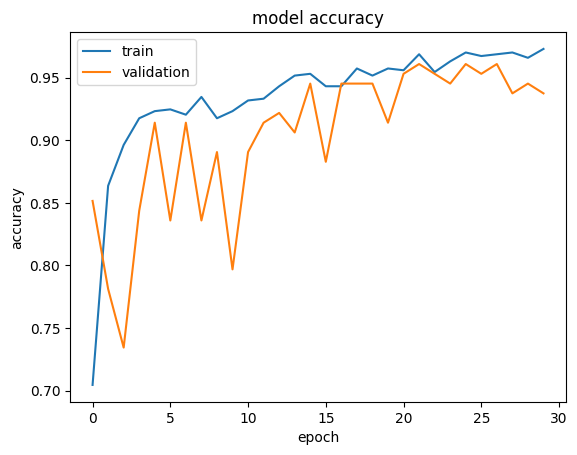

In [12]:
plot_hist(hist)

2024-12-22 13:57:48.557681: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 44s 21s/step


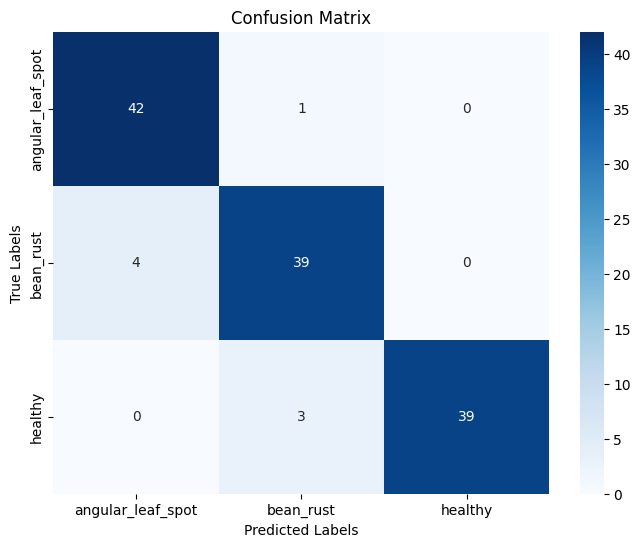

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Convert true labels to single-label format
true_labels = np.concatenate([np.argmax(y, axis=1) for x, y in ds_test], axis=0)

# Step 2: Get predicted labels (already handled with np.argmax)
predictions = model.predict(ds_test, batch_size=BATCH_SIZE)
predicted_labels = np.argmax(predictions, axis=1)

# Step 3: Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

class_names = ds_info.features['label'].names
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [14]:
from sklearn.metrics import classification_report
# Calculate accuracy
accuracy = np.mean(true_labels == predicted_labels)
print(f"Accuracy: {accuracy:.2f}")
# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)

print(report)

Accuracy: 0.94
                   precision    recall  f1-score   support

angular_leaf_spot       0.91      0.98      0.94        43
        bean_rust       0.91      0.91      0.91        43
          healthy       1.00      0.93      0.96        42

         accuracy                           0.94       128
        macro avg       0.94      0.94      0.94       128
     weighted avg       0.94      0.94      0.94       128

